In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_df = pd.read_csv('train_data.csv').dropna(subset=['text', 'sentiment'])
# train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_df = pd.read_csv('test_data.csv').dropna(subset=['text', 'sentiment'])
# test_df = test_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [4]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 128
BATCH_SIZE = 256
EPOCHS = 25

In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

In [6]:
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

y_train = np.array(train_df['sentiment']).astype(np.float32)
y_test = np.array(test_df['sentiment']).astype(np.float32)

# Podział na zbiór walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [8]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SimpleGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])
        x = self.sigmoid(self.fc(x))
        return x


In [9]:
model = SimpleGRU(MAX_NUM_WORDS, EMBEDDING_DIM, 32).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
train_acc, val_acc, train_loss, val_loss = [], [], [], []
from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss.append(total_loss / total)
    train_acc.append(correct / total)

    # Walidacja
    model.eval()
    with torch.no_grad():
        val_total_loss, val_correct, val_total = 0, 0, 0
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_total_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss.append(val_total_loss / val_total)
    val_acc.append(val_correct / val_total)
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Acc: {train_acc[-1]:.4f} | "
        f"Train Loss: {train_loss[-1]:.4f} | "
        f"Val Acc: {val_acc[-1]:.4f} | "
        f"Val Loss: {val_loss[-1]:.4f}"
    )



Epoch 1/25 [Train]: 100%|██████████| 3981/3981 [00:29<00:00, 132.80it/s]


Epoch 1/25 | Train Acc: 0.7578 | Train Loss: 0.4944 | Val Acc: 0.7824 | Val Loss: 0.4594


Epoch 2/25 [Train]: 100%|██████████| 3981/3981 [00:28<00:00, 141.21it/s]


Epoch 2/25 | Train Acc: 0.7877 | Train Loss: 0.4528 | Val Acc: 0.7880 | Val Loss: 0.4514


Epoch 3/25 [Train]: 100%|██████████| 3981/3981 [00:28<00:00, 140.94it/s]


Epoch 3/25 | Train Acc: 0.7944 | Train Loss: 0.4413 | Val Acc: 0.7900 | Val Loss: 0.4478


Epoch 4/25 [Train]: 100%|██████████| 3981/3981 [00:26<00:00, 148.95it/s]


Epoch 4/25 | Train Acc: 0.7992 | Train Loss: 0.4329 | Val Acc: 0.7900 | Val Loss: 0.4473


Epoch 5/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 143.07it/s]


Epoch 5/25 | Train Acc: 0.8037 | Train Loss: 0.4254 | Val Acc: 0.7903 | Val Loss: 0.4465


Epoch 6/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 145.84it/s]


Epoch 6/25 | Train Acc: 0.8085 | Train Loss: 0.4180 | Val Acc: 0.7898 | Val Loss: 0.4476


Epoch 7/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 144.80it/s]


Epoch 7/25 | Train Acc: 0.8129 | Train Loss: 0.4105 | Val Acc: 0.7896 | Val Loss: 0.4513


Epoch 8/25 [Train]: 100%|██████████| 3981/3981 [00:29<00:00, 134.29it/s]


Epoch 8/25 | Train Acc: 0.8169 | Train Loss: 0.4038 | Val Acc: 0.7885 | Val Loss: 0.4522


Epoch 9/25 [Train]: 100%|██████████| 3981/3981 [00:29<00:00, 134.73it/s]


Epoch 9/25 | Train Acc: 0.8213 | Train Loss: 0.3966 | Val Acc: 0.7877 | Val Loss: 0.4533


Epoch 10/25 [Train]: 100%|██████████| 3981/3981 [00:29<00:00, 133.82it/s]


Epoch 10/25 | Train Acc: 0.8255 | Train Loss: 0.3895 | Val Acc: 0.7872 | Val Loss: 0.4579


Epoch 11/25 [Train]: 100%|██████████| 3981/3981 [00:28<00:00, 140.25it/s]


Epoch 11/25 | Train Acc: 0.8293 | Train Loss: 0.3827 | Val Acc: 0.7861 | Val Loss: 0.4632


Epoch 12/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 144.14it/s]


Epoch 12/25 | Train Acc: 0.8331 | Train Loss: 0.3763 | Val Acc: 0.7851 | Val Loss: 0.4652


Epoch 13/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 147.44it/s]


Epoch 13/25 | Train Acc: 0.8370 | Train Loss: 0.3703 | Val Acc: 0.7834 | Val Loss: 0.4718


Epoch 14/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 143.92it/s]


Epoch 14/25 | Train Acc: 0.8404 | Train Loss: 0.3646 | Val Acc: 0.7833 | Val Loss: 0.4758


Epoch 15/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 142.48it/s]


Epoch 15/25 | Train Acc: 0.8436 | Train Loss: 0.3589 | Val Acc: 0.7819 | Val Loss: 0.4766


Epoch 16/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 145.04it/s]


Epoch 16/25 | Train Acc: 0.8464 | Train Loss: 0.3539 | Val Acc: 0.7821 | Val Loss: 0.4811


Epoch 17/25 [Train]: 100%|██████████| 3981/3981 [00:26<00:00, 148.17it/s]


Epoch 17/25 | Train Acc: 0.8491 | Train Loss: 0.3488 | Val Acc: 0.7809 | Val Loss: 0.4829


Epoch 18/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 144.36it/s]


Epoch 18/25 | Train Acc: 0.8513 | Train Loss: 0.3451 | Val Acc: 0.7801 | Val Loss: 0.4878


Epoch 19/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 144.47it/s]


Epoch 19/25 | Train Acc: 0.8538 | Train Loss: 0.3405 | Val Acc: 0.7787 | Val Loss: 0.4912


Epoch 20/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 146.17it/s]


Epoch 20/25 | Train Acc: 0.8555 | Train Loss: 0.3368 | Val Acc: 0.7787 | Val Loss: 0.4978


Epoch 21/25 [Train]: 100%|██████████| 3981/3981 [00:28<00:00, 141.64it/s]


Epoch 21/25 | Train Acc: 0.8578 | Train Loss: 0.3332 | Val Acc: 0.7778 | Val Loss: 0.4966


Epoch 22/25 [Train]: 100%|██████████| 3981/3981 [00:26<00:00, 150.05it/s]


Epoch 22/25 | Train Acc: 0.8592 | Train Loss: 0.3299 | Val Acc: 0.7778 | Val Loss: 0.5031


Epoch 23/25 [Train]: 100%|██████████| 3981/3981 [00:28<00:00, 141.55it/s]


Epoch 23/25 | Train Acc: 0.8611 | Train Loss: 0.3272 | Val Acc: 0.7774 | Val Loss: 0.5044


Epoch 24/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 144.85it/s]


Epoch 24/25 | Train Acc: 0.8623 | Train Loss: 0.3249 | Val Acc: 0.7774 | Val Loss: 0.5071


Epoch 25/25 [Train]: 100%|██████████| 3981/3981 [00:27<00:00, 143.84it/s]
                                                                     

Epoch 25/25 | Train Acc: 0.8637 | Train Loss: 0.3219 | Val Acc: 0.7771 | Val Loss: 0.5077


In [11]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = correct / total
    print(f"\nDokładność na danych testowych: {test_acc:.4f}")


Dokładność na danych testowych: 0.7783


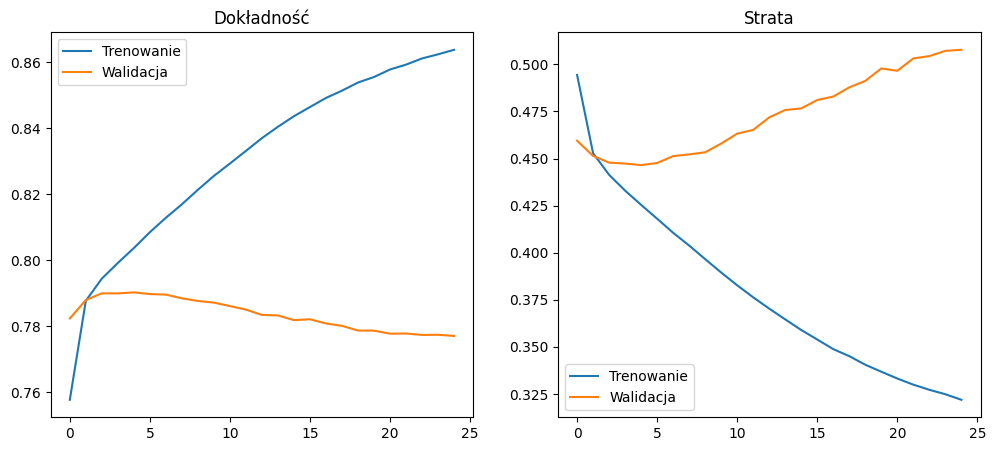

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Trenowanie')
plt.plot(val_acc, label='Walidacja')
plt.title('Dokładność')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Trenowanie')
plt.plot(val_loss, label='Walidacja')
plt.title('Strata')
plt.legend()

plt.show()

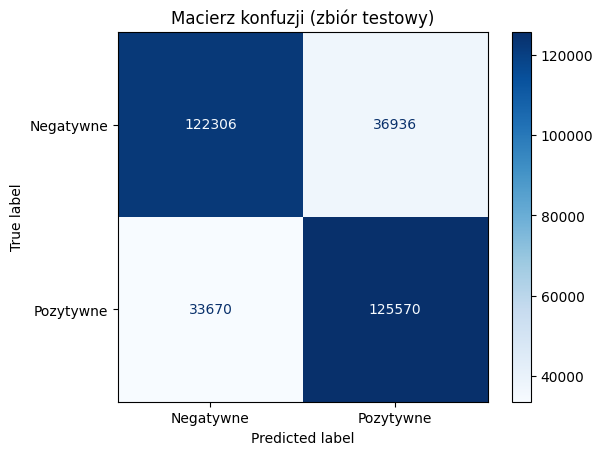

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negatywne", "Pozytywne"])

# Wyświetlenie
disp.plot(cmap='Blues')
plt.title('Macierz konfuzji (zbiór testowy)')
plt.show()
